# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

### Carga de datos

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df.sample(5)

,datetime,num_orders
1801,2018-03-13 12:10:00,3
8535,2018-04-29 06:30:00,0
10916,2018-05-15 19:20:00,8
19383,2018-07-13 14:30:00,26
13831,2018-06-05 01:10:00,11


In [5]:
#Cambiar tipo de datos de columna datetime de object a datetime
df['datetime'] = pd.to_datetime(df['datetime'])

In [6]:
#Comprobar que se realizo correctamente el cambio de tipo de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [7]:
#Definir la columna datetime como index
df.set_index('datetime', inplace = True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
#Verificar si las fechas estan en orden cronologico
print(df.index.is_monotonic)

True


In [10]:
#Hacer remuestreo por 1 hora
data = df.resample('1H').sum()

## Análisis

<AxesSubplot:xlabel='datetime'>

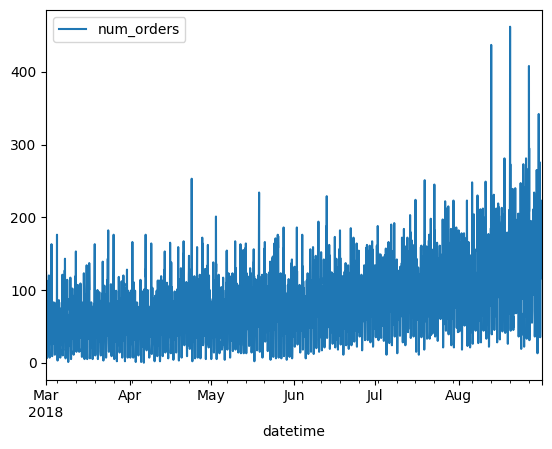

In [11]:
#Crear grafico de los datos
data.plot()

In [12]:
#Obtener tendencia, estacionalidad y residuos de la serie de datos
decomposed = seasonal_decompose(data['num_orders'])

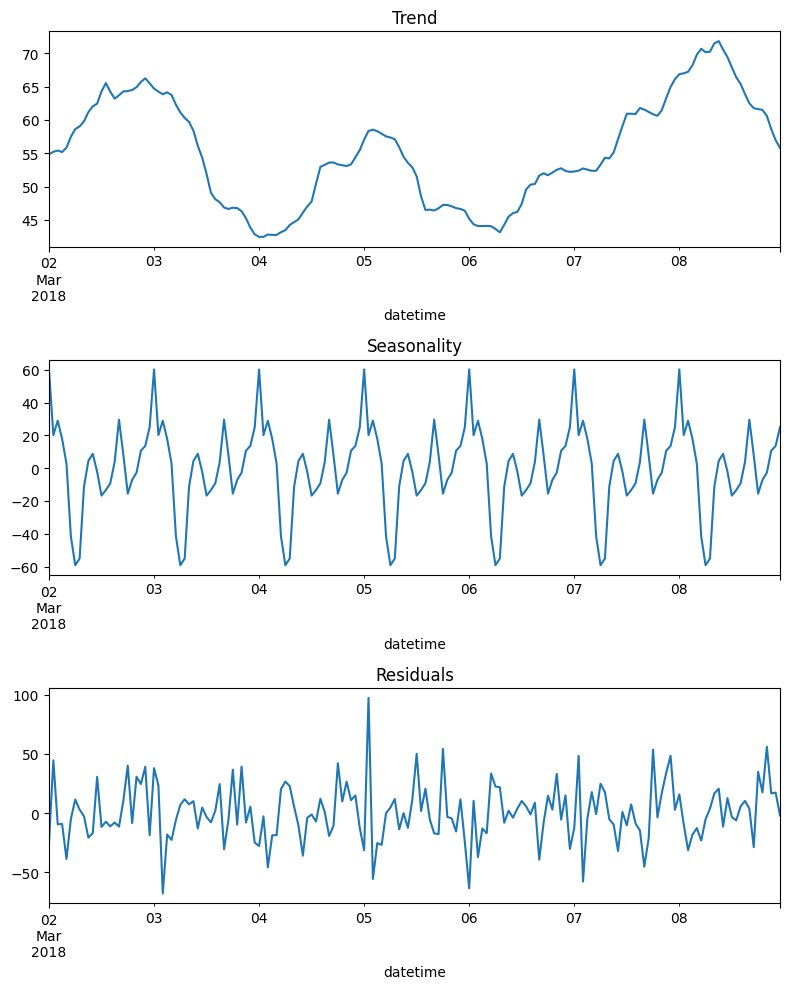

In [13]:
#Crear grafico para tendencia, estacionalidad y residuos de los datos del 2 al 8 de marzo.
plt.figure(figsize=(8, 10))
plt.subplot(311)
decomposed.trend['2018-03-02':'2018-03-08'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-02':'2018-03-08'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-03-02':'2018-03-08'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Se observa un patron en la grafica de estacionalidad que se repite cada día

## Formación

In [14]:
#Crear funcion para creación de caracteristicas
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (data['num_orders'].shift().rolling(rolling_mean_size).mean())

In [15]:
make_features(data, 5, 10)

In [16]:
data.head(10)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,NaN
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,NaN
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,NaN


In [17]:
#Dividir en conjunto de entrenamiento y de prueba
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [18]:
#Seleccionar features y target para los dos conjuntos
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Modelo de regresión lineal

In [19]:
#Llamar a modelo de regresión lineal
model_lr = LinearRegression()

In [20]:
#Realizar entrenamiento de modelo con conjunto de entrenamiento
model_lr.fit(features_train, target_train)

LinearRegression()

### Modelo de bosque aleatorio

In [21]:
#Llamar a modelo de bosque aleatorio
model_rfr = RandomForestRegressor(max_depth=10, n_estimators=10, random_state=54321)

In [22]:
#Realizar entrenamiento de modelo con conjunto de entrenamiento
model_rfr.fit(features_train, target_train)

RandomForestRegressor(max_depth=10, n_estimators=10, random_state=54321)

### Modelo Catboost

In [23]:
#Definir caracteristicas categóricas
cat_features = ['month', 'day', 'dayofweek', 'hour']

In [24]:
#Llamar a modelo de bosque aleatorio y definir hiperparámetros.
model_catboost = CatBoostRegressor(cat_features = cat_features, max_depth=7, learning_rate=0.5, n_estimators=200, random_seed=12345, simple_ctr='Counter')

In [25]:
#Realizar entrenamiento de modelo con conjunto de entrenamiento
model_catboost.fit(features_train, target_train)

Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.


0:	learn: 33.6669804	total: 57.8ms	remaining: 11.5s
1:	learn: 29.0548466	total: 70.2ms	remaining: 6.95s
2:	learn: 26.5374592	total: 82.2ms	remaining: 5.4s
3:	learn: 24.9407845	total: 94.2ms	remaining: 4.62s
4:	learn: 24.2852874	total: 106ms	remaining: 4.14s
5:	learn: 23.3811054	total: 116ms	remaining: 3.75s
6:	learn: 23.2431479	total: 125ms	remaining: 3.44s
7:	learn: 22.9070121	total: 138ms	remaining: 3.3s
8:	learn: 22.8474859	total: 145ms	remaining: 3.08s
9:	learn: 22.5094457	total: 156ms	remaining: 2.97s
10:	learn: 22.1668065	total: 168ms	remaining: 2.88s
11:	learn: 22.0255480	total: 179ms	remaining: 2.8s
12:	learn: 21.9858530	total: 184ms	remaining: 2.65s
13:	learn: 21.9092583	total: 194ms	remaining: 2.57s
14:	learn: 21.6404842	total: 205ms	remaining: 2.53s
15:	learn: 21.5101937	total: 217ms	remaining: 2.5s
16:	learn: 21.4863598	total: 222ms	remaining: 2.39s
17:	learn: 21.3227314	total: 231ms	remaining: 2.33s
18:	learn: 20.9231908	total: 243ms	remaining: 2.32s
19:	learn: 20.8225249	

168:	learn: 11.7272528	total: 1.89s	remaining: 347ms
169:	learn: 11.6936100	total: 1.9s	remaining: 336ms
170:	learn: 11.6531150	total: 1.92s	remaining: 325ms
171:	learn: 11.6207701	total: 1.93s	remaining: 314ms
172:	learn: 11.5722015	total: 1.94s	remaining: 303ms
173:	learn: 11.5442377	total: 1.95s	remaining: 292ms
174:	learn: 11.4942952	total: 1.96s	remaining: 280ms
175:	learn: 11.4779817	total: 1.97s	remaining: 269ms
176:	learn: 11.4608280	total: 1.99s	remaining: 258ms
177:	learn: 11.4317431	total: 2s	remaining: 247ms
178:	learn: 11.4004631	total: 2.01s	remaining: 236ms
179:	learn: 11.3839588	total: 2.02s	remaining: 224ms
180:	learn: 11.3513035	total: 2.03s	remaining: 213ms
181:	learn: 11.3376273	total: 2.04s	remaining: 202ms
182:	learn: 11.3114826	total: 2.05s	remaining: 191ms
183:	learn: 11.2974550	total: 2.06s	remaining: 179ms
184:	learn: 11.2913270	total: 2.07s	remaining: 168ms
185:	learn: 11.2434666	total: 2.08s	remaining: 157ms
186:	learn: 11.1776745	total: 2.1s	remaining: 146m

## Prueba

### Prueba de modelo de regresión lineal

In [26]:
#Realizar predicciones del conjunto de prueba
pred_test_lr = model_lr.predict(features_test)

In [27]:
#Calcular RECM para el conjunto de prueba
print("RECM para el conjunto de prueba:", mean_squared_error(target_test, pred_test_lr) ** 0.5)

RECM para el conjunto de prueba: 53.1002280636477


### Prueba de modelo de bosque aleatorio

In [28]:
#Realizar predicciones del conjunto de prueba
pred_test_rfr = model_rfr.predict(features_test)

In [29]:
#Calcular RECM para el conjunto de prueba
print("RECM para el conjunto de prueba:", mean_squared_error(target_test, pred_test_rfr) ** 0.5)

RECM para el conjunto de prueba: 44.748984108264914


### Prueba modelo catboost

In [30]:
#Realizar predicciones del conjunto de prueba
pred_test_ctbt = model_catboost.predict(features_test)

In [31]:
#Calcular RECM para el conjunto de prueba
print("RECM para el conjunto de prueba:", mean_squared_error(target_test, pred_test_ctbt) ** 0.5)

RECM para el conjunto de prueba: 42.71231473792277


## Conclusión

Este proyecto se enfocó en la realización de predicciones de series temporales. Se remuestrearon los datos por periodos de 1 hora ya que el objetivo del proyecto es poder predecir la cantidad de ordenes de taxis para la siguiente hora.
En el análsis de los datos de encontró un patrón que se repite diariamente.
Se probaron 3 modelos diferentes para realizar las predicciones, regresión lineal, bosque aleatorio y potenciacion de gradiente catboost. El método de regresión lineal no consiguió el objetivo de RECM menor a 48, en los otros dos modelos si se logró el objetivo y el mejor modelo con un RECM de 42.7 fue el de potenciación de gradiente catboost.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48